In [6]:
import numpy as np
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from nltk.corpus import stopwords
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import pprint
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Read in data

In [8]:
peek = 10
def present_list_like(name, list_like, peek=peek):
    print(f"{name} peek:")
    print('  ' + '\n  '.join([str(seq) for seq in list_like[0:peek]]))

In [9]:
#Read data from covid_lies.csv dataset into dataframe
df = pd.read_csv('./data/covid_lies.csv')
print("The dataset:")
df.info()
print("\nData peek:")
print(df.head(peek))
print()

#Seperate out text data(X) and labels(y)
input_text = df['misconception'].to_numpy()
input_label = df['label'].to_numpy()

#Convert labels to binary values('pos' vs 'neg')
#df['label'] = input_label = np.array(['pos' if label == 'pos' else 'neg' for label in df['label'].values])

#Inspect labels
print("Unique labels:", np.unique(input_label))
orig_label_counts = df['label'].value_counts(normalize=True)
print("Counts of 'labels':", orig_label_counts)

The dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6591 entries, 0 to 6590
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   misconception_id  6591 non-null   int64 
 1   misconception     6591 non-null   object
 2   tweet_id          6591 non-null   int64 
 3   label             6591 non-null   object
dtypes: int64(2), object(2)
memory usage: 206.1+ KB

Data peek:
   misconception_id                                      misconception  \
0                 3             Coronavirus is genetically engineered.   
1                30  Blowing conch shells destroys coronavirus pote...   
2                57  Swans and dolphins swimming in Venice canals f...   
3                22                         Cocaine cures coronavirus.   
4                32  Observing janata curfew will result in the red...   
5                25  Holy communion cannot be the cause of the spre...   
6                61  Li

## Preprocess input data

In [10]:
def preprocess_text(text)->str:
    #Letter-level cleaning
    text = text.lower()
    valid_asciis = {9, *range(32, 127)}
    text = ''.join(filter(lambda x: ord(x) in valid_asciis, text))

    #Word/sequence-level cleaning
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text


In [11]:
#Preprocess the text
for i in range(len(input_text)):
    input_text[i] = preprocess_text(input_text[i])

## Tokenize input text data

In [12]:
#Tokenize the text

input_tokens = [nltk.word_tokenize(text) for text in input_text]

# Split tokens based on non-alphanumeric characters
final_tokens = []
total_tokens = 0
for token_set in input_tokens:
    final_tkn_set = []
    for tk in token_set:
        sub_tkns = [c for c in re.split(r"(\W+)", tk) if c]
        total_tokens += len(sub_tkns)
        final_tkn_set += sub_tkns
    final_tokens.append(final_tkn_set)
present_list_like(f"Tokenized sentences({len(final_tokens)} sentences, {total_tokens} tokens)", final_tokens)

Tokenized sentences(6591 sentences, 51404 tokens) peek:
  ['coronavirus', 'genetically', 'engineered', '.']
  ['blowing', 'conch', 'shells', 'destroys', 'coronavirus', 'potency', '.']
  ['swans', 'dolphins', 'swimming', 'venice', 'canals', 'following', 'covid', '-', '19', 'lockdown', '.']
  ['cocaine', 'cures', 'coronavirus', '.']
  ['observing', 'janata', 'curfew', 'result', 'reduction', 'covid', '-', '19', 'cases', '40', '%', '.']
  ['holy', 'communion', 'can', 'not', 'cause', 'spread', 'coronavirus']
  ['lions', 'freed', 'keep', 'people', 'streets', 'moscow', '.']
  ['coronavirus', 'genetically', 'engineered', '.']
  ['cannabis', 'protects', 'covid', '-', '19', '.']
  ['safe', 'individuals', 'infected', 'covid', '-', '19', 'go', 'work', '.']


## Form embeddings for input data

In [13]:
#Embed the tokens

# Map each token to its frequency in the dataset
flat_tokens = [word for token_set in final_tokens for word in token_set]
frequencies = Counter(flat_tokens)
token_to_idx = {word: idx+1 for idx, (word, _) in enumerate(frequencies.most_common())}
vocab_size = len(token_to_idx)
print(vocab_size, "unique tokens")
present_list_like("Unique tokens", list(token_to_idx.keys()))

# Embed the tokens
freq_indexed = [[token_to_idx[token] for token in token_set] for token_set in final_tokens]

# Make embeddings the same size
forced_idx_set_size = max(len(idxs) for idxs in freq_indexed)
freq_indexed = [
    idxs[:forced_idx_set_size] + [0]*(forced_idx_set_size - len(idxs))
    for idxs in freq_indexed
]
present_list_like(f"\nFinal Index Sets(Set_Size = {forced_idx_set_size}, {len(freq_indexed)} index sets)", freq_indexed)

266 unique tokens
Unique tokens peek:
  .
  coronavirus
  -
  covid
  19
  cure
  cures
  ,
  '
  vitamin

Final Index Sets(Set_Size = 19, 6591 index sets) peek:
  [2, 27, 28, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  [53, 54, 55, 56, 2, 57, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  [58, 59, 60, 41, 42, 11, 4, 3, 5, 12, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  [61, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  [219, 220, 221, 222, 223, 4, 3, 5, 224, 225, 226, 1, 0, 0, 0, 0, 0, 0, 0]
  [47, 48, 13, 14, 49, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  [62, 63, 64, 65, 30, 66, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  [2, 27, 28, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  [67, 24, 4, 3, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  [68, 69, 31, 4, 3, 5, 70, 71, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Define and train a GRU model using PyTorch

In [14]:
#Define the model

import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, hidden = self.gru(self.embedding(x))
        return self.fc(hidden[-1])

In [15]:
#Training fn
def train_model(model, dataloader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_tps = 0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(inputs).squeeze()
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() #Track total loss
            #Track total accuracy
            _, predicted_classes = torch.max(predictions, 1)
            epoch_tps += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/len(dataloader):.4f} | Accuracy: {epoch_tps/total_samples:.4f}")

In [29]:
def show_balanced(y_train_balanced, label_ordering):
    balanced_class_counts = Counter(y_train_balanced.numpy())
    print("Balanced class distribution:", {label_ordering[i]: count for i, count in balanced_class_counts.items()})
    print(X_train_balanced.size(0), "balanced training samples of shape", X_train_balanced.shape)

def balance_via_sampling(X_train, y_train, label_ordering):
    #Balance classes in training sets via resampling

    X_train = X_train.numpy()
    y_train = y_train.numpy()

    # Count the number of samples in each class
    class_counts = Counter(y_train)
    print("Original class distribution:", class_counts)
    max_samples = max(class_counts.values())

    # Resample the training data
    X_train_balanced = []
    y_train_balanced = []
    for class_label in class_counts.keys():
        #Perform oversampling for the current class
        class_mask = (y_train == class_label)
        X_class = X_train[class_mask]
        y_class = y_train[class_mask]
        X_class_resampled, y_class_resampled = resample(
            X_class,
            y_class,
            replace=True,
            n_samples=max_samples,
            random_state=42
        )
        X_train_balanced.append(X_class_resampled)
        y_train_balanced.append(y_class_resampled)

    # Combine resampled data for all classes
    X_train_balanced = torch.tensor(np.vstack(X_train_balanced), dtype=torch.long)
    y_train_balanced = torch.tensor(np.hstack(y_train_balanced), dtype=torch.long)

    # Print the new class distribution, return results
    show_balanced(y_train_balanced, label_ordering)
    return X_train_balanced, y_train_balanced


def balance_via_synthesis(X_train, y_train, label_ordering):
    #Balance classes in training sets via synthetic sample creation via SMOTE

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train.numpy(), y_train.numpy())
    X_train_balanced = torch.tensor(X_train_balanced, dtype=torch.long)
    y_train_balanced = torch.tensor(y_train_balanced, dtype=torch.long)

    # Print the new class distribution, return results
    show_balanced(y_train_balanced, label_ordering)
    return X_train_balanced, y_train_balanced

In [31]:
#Setup to train

# Model and training structure
INPUT_DIM = vocab_size + 1
EMBEDDING_DIM = 15000
HIDDEN_DIM = 128
OUTPUT_DIM = orig_label_counts.shape[0]
N_LAYERS = 2
DROPOUT = 0.2
BATCH_SIZE = 64
EPOCHS = 30

# Make the model
gru_model = GRUModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
print("Model:", gru_model)

# Optimization & loss setup
optimizer = torch.optim.AdamW(gru_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Move model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = gru_model.to(device)
criterion = criterion.to(device)

# Setup the training dataset
X = torch.tensor(freq_indexed, dtype=torch.long)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(input_label)
y = torch.tensor(y, dtype=torch.long)
print(X.size(0), "overall samples of shape", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)
X_train, X_test = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_test, dtype=torch.long)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)
print(X_train.size(0), "training samples of shape", X_train.shape)
print(y_test.size(0), "validation samples of shape", X_test.shape)

# Balance the training data
X_train_balanced, y_train_balanced = balance_via_synthesis(X_train, y_train, label_encoder.classes_)

# Create train and test datasets
train_dataset = TensorDataset(X_train_balanced, y_train_balanced)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Model: GRUModel(
  (embedding): Embedding(267, 15000)
  (gru): GRU(15000, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
6591 overall samples of shape torch.Size([6591, 19])
5272 training samples of shape torch.Size([5272, 19])
1319 validation samples of shape torch.Size([1319, 19])
Balanced class distribution: {'na': 4923, 'pos': 4923, 'neg': 4923}
14769 balanced training samples of shape torch.Size([14769, 19])


In [32]:
#Train the model
train_model(gru_model, train_loader, optimizer, criterion, device, EPOCHS)

Epoch 1/30 | Loss: 0.6312 | Accuracy: 0.7441
Epoch 2/30 | Loss: 0.5583 | Accuracy: 0.7722
Epoch 3/30 | Loss: 0.5436 | Accuracy: 0.7785
Epoch 4/30 | Loss: 0.5350 | Accuracy: 0.7820
Epoch 5/30 | Loss: 0.5285 | Accuracy: 0.7853
Epoch 6/30 | Loss: 0.5243 | Accuracy: 0.7879
Epoch 7/30 | Loss: 0.5212 | Accuracy: 0.7873
Epoch 8/30 | Loss: 0.5178 | Accuracy: 0.7902
Epoch 9/30 | Loss: 0.5148 | Accuracy: 0.7892
Epoch 10/30 | Loss: 0.5131 | Accuracy: 0.7899
Epoch 11/30 | Loss: 0.5128 | Accuracy: 0.7890
Epoch 12/30 | Loss: 0.5133 | Accuracy: 0.7897
Epoch 13/30 | Loss: 0.5102 | Accuracy: 0.7908
Epoch 14/30 | Loss: 0.5077 | Accuracy: 0.7916
Epoch 15/30 | Loss: 0.5069 | Accuracy: 0.7906
Epoch 16/30 | Loss: 0.5066 | Accuracy: 0.7908
Epoch 17/30 | Loss: 0.5076 | Accuracy: 0.7921
Epoch 18/30 | Loss: 0.5065 | Accuracy: 0.7915
Epoch 19/30 | Loss: 0.5057 | Accuracy: 0.7921
Epoch 20/30 | Loss: 0.5047 | Accuracy: 0.7929
Epoch 21/30 | Loss: 0.5043 | Accuracy: 0.7927
Epoch 22/30 | Loss: 0.5079 | Accuracy: 0.79

## Save Model Weights

In [33]:
#Save the model weights
torch.save(gru_model.state_dict(), "gru_model_weights.pth")
print("Model weights saved to 'gru_model_weights.pth'")

Model weights saved to 'gru_model_weights.pth'


## Evaluate Model

In [34]:
#Evaluation functions
import typing as tp

# Get predictions
def get_predictions(
    test_loader, model, num_samples,
    pred_type: tp.Literal['model', 'baseline', 'random'] = 'model',
    device=None,
    label_ordering=None, orig_label_counts=None,
    num_classes=None
):
    predictions = []
    y_test = []

    if pred_type == 'model':
        model.eval()
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                y_test.extend(batch_y)

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                batch_size = batch_X.size(0)

                outputs = model(batch_X).squeeze()
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu())
        y_test = torch.tensor(y_test, dtype=torch.long)
    elif pred_type == 'baseline':
        orig_label_counts = orig_label_counts.sort_index(key=lambda idx: orig_label_counts[idx], inplace=False, ascending=False)
        majority_class = list(label_ordering).index(orig_label_counts.index[0])
        predictions += [majority_class for _ in range(num_samples)]
    else:
        predictions += [random.randint(0, num_classes - 1) for _ in range(num_samples)]

    predictions = torch.tensor(predictions, dtype=torch.long)
    if pred_type == 'model':
        return predictions, y_test
    return predictions

# Calculate per-class metrics
def per_class_metrics(labels, predictions, num_classes, label_ordering):
    precision_per_class = precision_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)
    recall_per_class = recall_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)
    f1_per_class = f1_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)

    results = []
    for metrics in [precision_per_class, recall_per_class, f1_per_class]:
        results.append({label_ordering[i]: metrics[i] for i in range(len(metrics))})
    return tuple(results)

# Calculate Macro metrics
def macro_metrics(labels, predictions):
    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)

    return precision_macro, recall_macro, f1_macro

# Calculate Micro metrics
def micro_metrics(labels, predictions):
    precision_micro = precision_score(labels, predictions, average='micro', zero_division=0)
    recall_micro = recall_score(labels, predictions, average='micro', zero_division=0)
    f1_micro = f1_score(labels, predictions, average='micro', zero_division=0)

    return precision_micro, recall_micro, f1_micro

# Get evaluations
def evaluate(labels, model_pred, baseline_pred, random_pred, label_ordering):
    results = {}

    for pred_type, predictions in [('Model', model_pred), ('Baseline', baseline_pred), ('Random', random_pred)]:
        curr_results = results[pred_type] = {}

        #Calculate metrics
        accuracy = (predictions == labels).sum().item() / labels.size(0)
        precision_per_class, recall_per_class, f1_per_class = per_class_metrics(labels, predictions, num_classes, label_ordering)
        precision_macro, recall_macro, f1_macro = macro_metrics(labels, predictions)
        precision_micro, recall_micro, f1_micro = micro_metrics(labels, predictions)

        #Save all metrics
        curr_results["Accuracy"] = accuracy
        curr_results["Per-Class Precision"] = precision_per_class
        curr_results["Per-Class Recall"] = recall_per_class
        curr_results["Per-Class F1"] = f1_per_class

        curr_results["Macro Precision"] = precision_macro
        curr_results["Macro Recall"] = recall_macro
        curr_results["Macro F1"] = f1_macro

        curr_results["Micro Precision"]  = precision_micro
        curr_results["Micro Recall"] = recall_micro
        curr_results["Micro F1"] = f1_micro

    return results


{'Baseline': {'Accuracy': 0.9294920394238059,
              'Macro F1': 0.32115258677144726,
              'Macro Precision': 0.30983067980793527,
              'Macro Recall': 0.3333333333333333,
              'Micro F1': 0.9294920394238059,
              'Micro Precision': 0.9294920394238059,
              'Micro Recall': 0.9294920394238059,
              'Per-Class F1': {'na': 0.9634577603143418,
                               'neg': 0.0,
                               'pos': 0.0},
              'Per-Class Precision': {'na': 0.9294920394238059,
                                      'neg': 0.0,
                                      'pos': 0.0},
              'Per-Class Recall': {'na': 1.0, 'neg': 0.0, 'pos': 0.0}},
 'Model': {'Accuracy': 0.7983320697498104,
           'Macro F1': 0.5155207749722205,
           'Macro Precision': 0.4723047066287612,
           'Macro Recall': 0.7492535834157031,
           'Micro F1': 0.7983320697498104,
           'Micro Precision': 0.79833206974981

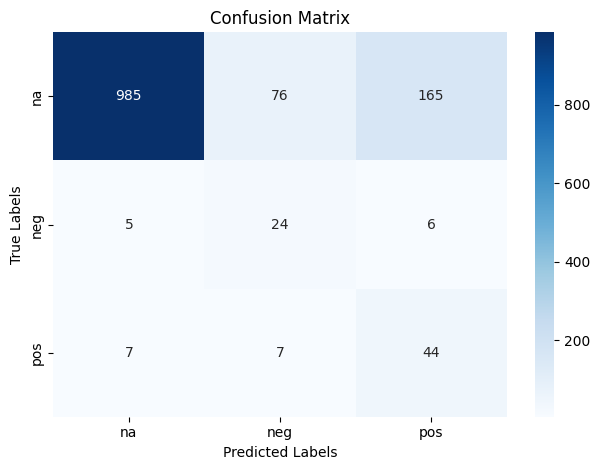

In [35]:
#Evaluate and show results

# Setup
num_classes = OUTPUT_DIM

# Get model, baseline, and random predictions
#  Use model predictions to get the test labels since the
#   test loader shuffles its values and is not in the same order as y_test upon iteration
model_pred, labels = get_predictions(test_loader, gru_model, y_test.size(0), pred_type='model', device=device)
#  Get other prediction types as normal
baseline_pred = get_predictions(
    test_loader, gru_model, y_test.size(0), pred_type='baseline',
    label_ordering=label_encoder.classes_, orig_label_counts=orig_label_counts
)
random_pred = get_predictions(test_loader, gru_model, y_test.size(0), pred_type='random', num_classes=num_classes)

print()

# Print evaluation results
pprint.pprint(evaluate(labels, model_pred, baseline_pred, random_pred, label_encoder.classes_))

# Generate confusion matrix
conf_matrix = confusion_matrix(labels, model_pred)
class_labels = label_encoder.classes_

#  Plot the confusion matrix as a heatmap
def plot_confusion_matrix(conf_matrix, class_labels):
    sns.heatmap(
        conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
        xticklabels=class_labels, yticklabels=class_labels
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()
print("\n")
plot_confusion_matrix(conf_matrix, class_labels)
